<a href="https://colab.research.google.com/github/UsaMasa/Python/blob/master/GAN%E7%B7%B4%E7%BF%92%E3%83%8E%E3%83%BC%E3%83%88%E3%83%96%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN) 入門

## 目標
シンプルなGANの実装を通して、敵対生成ネットワークの基礎を学ぶ。

## 概要
本物の分布データとして、平均5、分散1.5のガウス分布を想定する。generatorは乱数生成されたノイズインプットを元に、生成データ（偽物）を生成する。generatorはdiscriminatorを騙すように学習し、discriminatorは本物と偽物を見分けるように学習していくことで、競い合うようにして生成データの精度を上げていく、というのが大まかな流れである。

## 参考
本ノートブックはMLHEP day 6 の実習で用いられたノートブックを元にしている。
https://github.com/yandexdataschool/mlhep2019/blob/master/notebooks/day-6/06_1D_GAN.ipynb

## 実装

In [1]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00169201days (146.19sec)


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from scipy.stats import ks_2samp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
LATENT_DIM = 4
def sample_noise(batch_size):
    #[batch_size, LATENT_DIM] のサイズで、 [0, 1]　の範囲の一様な分布を返す（ノイズインプット）
    return torch.rand(batch_size, LATENT_DIM, device="cuda")

def sample_real_data(batch_size):
    #目標とする分布（gaus(5, 1.5)で[batch_size, 1]の形）のサンプルを返す
    return torch.randn(batch_size, 1, device="cuda") * 1.5 + 5

### GANのモデル生成
GeneratorとDiscriminatorを作成する。

In [0]:
# Generatorはノイズインプットを受け取って、1次元の応答を返す。
gen = nn.Sequential(nn.Linear(LATENT_DIM, 16), nn.ELU(),
                    nn.Linear(16, 16), nn.ELU(),
                    nn.Linear(16, 1)).cuda()
gen_opt = torch.optim.SGD(gen.parameters(), lr=1e-3)

# Discriminator　はデータを受け取って、一つの値（これのsoftmaxが”本物”である確率に相当する）を返す 
# 通常、diccriminator側がゲームを有利に進められるように、generator側より”強くする”と良いらしい
disc = nn.Sequential(nn.Linear(1, 32), nn.ELU(),
                     nn.Linear(32, 32), nn.ELU(),
                     nn.Linear(32, 1)).cuda()
disc_opt = torch.optim.SGD(disc.parameters(), lr=1e-3)

### 損失関数の設定
Discriminator側に、歴史的によく使われてきた損失関数として、cross-entropy
$$\mathscr{L}^{\text{discr}} =
-\mathbb{E}\log\left[P(\text{real is real})\right]
-\mathbb{E}\log\left[P(\text{fake is fake})\right]
=
-\mathbb{E}\left[\log D(x_\text{real})\right]
-\mathbb{E}\left[\log (1 - D(x_\text{fake}))\right] 
$$

がある。

一方でgenerator側の損失関数は選択の余地があり、
* 生成されたサンプル（false）が本物である（true）とラベルされるlikelihoodを最大化する
*生成されたサンプルが偽物であるとラベルされるlikelihoodを最小化する

すなわち、

$$\mathscr{L}^{\text{gen}} =
-\mathbb{E}\log\left[P(\text{fake is real})\right] =
-\mathbb{E}\left[\log (D(x_\text{fake}))\right]$$

OR

$$\mathscr{L}^{\text{gen}} =
\mathbb{E}\log\left[P(\text{fake is fake})\right] =
\mathbb{E}\left[\log (1 - D(x_\text{fake}))\right]$$
の二択になる。ここで$D(x)$はdiscriminatorがtrue/falseをアサインする確率を表す。


In [0]:
def train_disc(batch_size):

    # 実データ（本物）を受け取った時に、本物だと判断する確率log p(real | x)を計算する
    real_data = sample_real_data(batch_size)
    logp_real_is_real = F.logsigmoid(disc(real_data))
    
    noise = sample_noise(batch_size)
    gen_data = gen(noise)
    logp_gen_is_fake = torch.log(1 - F.sigmoid(disc(gen_data))) # log(p(fake is fake))
    #実装上の注意として、log(σ(x))の計算を安定させるにはlogsigmoidを使う。1-σ(x) = -σ(x)であることも用いる。
    disc_loss = torch.mean(- logp_real_is_real - logp_gen_is_fake)

    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()

In [0]:
def train_gen(batch_size):
        
    noise = sample_noise(batch_size) 
    gen_data = gen(noise) 
    logp_gen_is_real = -F.logsigmoid(disc(gen_data)) # logp(real | G(z)), つまりfake is realの損失関数
    gen_loss = torch.mean(logp_gen_is_real) #上の確率を最大化する
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

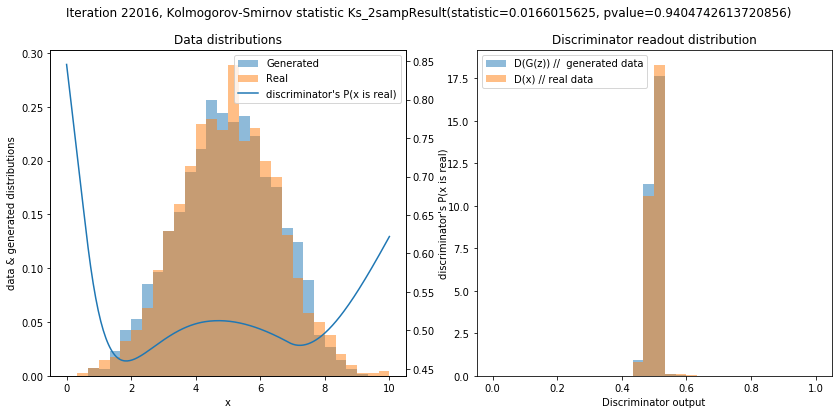

KeyboardInterrupt: ignored

In [32]:
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
TRAIN_BATCH_SIZE = 128
VALIDATION_BATCH_SIZE = 2048
VALIDATION_INTERVAL = 256
HIST_BINS=30
DATA_HIST_RANGE=[0, 10]

data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].cuda()

for i in range(100000):
    # discriminator側に有利な学習を行う（5 : 1）
    for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
        train_disc(TRAIN_BATCH_SIZE)
    
    train_gen(TRAIN_BATCH_SIZE)
    
    if i % VALIDATION_INTERVAL == 0:
        clear_output(True)
        validation_noise = sample_noise(VALIDATION_BATCH_SIZE)
        validation_data = sample_real_data(VALIDATION_BATCH_SIZE)
        validation_generated = gen(validation_noise)
        # dataとgenerated dataをnpへ変換する
        validation_generated_np = validation_generated.data.cpu().numpy()
        validation_data_np = validation_data.data.cpu().numpy()
        
        fig, (ax_data, ax_losses) = plt.subplots(ncols=2, figsize=[14, 6])
        ax_data.set_title("Data distributions")
        ax_data_plots = []
        ax_data_plots.append(ax_data.hist(validation_generated_np, range=DATA_HIST_RANGE,
                             alpha=0.5, density=True, label='Generated', bins=HIST_BINS)[2][0])
        ax_data_plots.append(ax_data.hist(validation_data_np, range=DATA_HIST_RANGE,
                             alpha=0.5, density=True, label='Real', bins=HIST_BINS)[2][0])
        ax_data.set_xlabel("x")
        ax_data.set_ylabel("data & generated distributions")
        disc_preal_np = torch.sigmoid(disc(data_linspace_torch)).data.cpu().numpy()
        ax_disc = ax_data.twinx()
        ax_data_plots.extend(ax_disc.plot(data_linspace_np, disc_preal_np, label="discriminator's P(x is real)"))
        ax_disc.set_ylabel("discriminator's P(x is real)")
        ax_data.legend(ax_data_plots, [o.get_label() for o in ax_data_plots], loc="best")

        ax_losses.set_title("Discriminator readout distribution")
        ax_losses.hist(torch.sigmoid(disc(validation_generated)).data.cpu().numpy(),
                 range=[0, 1], alpha=0.5, label='D(G(z)) //  generated data', bins=HIST_BINS, density=True)
        ax_losses.hist(torch.sigmoid(disc(validation_data)).data.cpu().numpy(),
                 range=[0, 1], alpha=0.5, label='D(x) // real data', bins=HIST_BINS, density=True)
        ax_losses.legend()
        ax_losses.set_xlabel("Discriminator output")
        fig.suptitle("Iteration {}, Kolmogorov-Smirnov statistic {}".format(
            i, ks_2samp(validation_generated_np.ravel(),
                        validation_data_np.ravel())))
        plt.show()

### 何が見えているのか？

*   左のヒストグラムは2つの分布（Generatorで生成された分布と、本物のデータの分布）が最初は異なっているが、学習が進むにつれてGenerator分布がデータ分布に合うようになっていく。青い線はDiscriminatorが本物だと判断するところであり、本物が多いところでは最終的に0.5に漸近する。
*   右のヒストグラムDiscriminatorが生成されたデータや、本物のデータをどう判断するか（True = 1, false = 0）のヒストグラムで、generator側の学習が進むにつれて、0.5に漸近する。

